In [29]:
import objective_functions as of
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


dataset_name = 'HD. Human Hair 25'

dir = '../results'
depthmap_method = 'FIJI.tif'
texture_method = 'ZS.jpg'


#input_texture_path = f'{dir}/{dataset_name}/Texture-{texture_method}'
input_texture_path = f'../datasets/20-Simple/frame73.jpg'
glob_threshold = 2

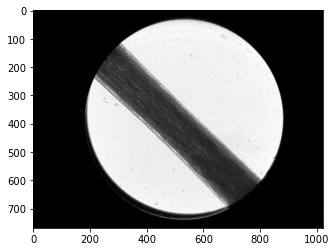

In [30]:
texture = cv.imread(input_texture_path, cv.IMREAD_COLOR)

# preprocess the texture
grayscale_texture = cv.cvtColor(texture, cv.COLOR_RGB2GRAY)
plt.imshow(grayscale_texture, cmap='gray')

In [31]:
# get the black background mask in order to afterwards transform the black background to
# be in the same cluster in Otsu's binarization as the bright one
threshold, black_background_mask = cv.threshold(grayscale_texture, glob_threshold, 255, cv.THRESH_BINARY_INV)

# find the brightest pixel - it will be used as a bright background value
minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(grayscale_texture)

# making sure that grayscaled_texture (<glob_threshold) + 255 * coeff < 255
coeff = np.min([maxVal / 255, 1 - glob_threshold / 255])

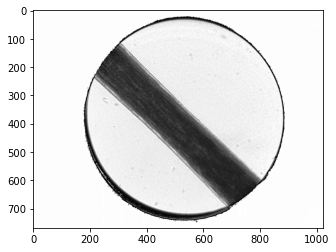

In [32]:
# adding 255 * coeff to the black background to set it bright
grayscale_texture = cv.addWeighted(grayscale_texture, 1, black_background_mask, coeff, 0)
plt.imshow(grayscale_texture, cmap='gray')

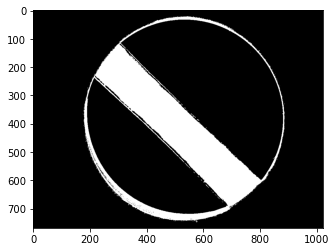

In [33]:
# apply otsu's binarization to the texture
th, mask = cv.threshold(grayscale_texture, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(mask, cmap='gray')

# apply mask to the depthmap and save the result
# masked_depth_map = cv.bitwise_and(depth_map, depth_map, mask=mask)
# cv.imwrite(output_depthmap_path, masked_depth_map)

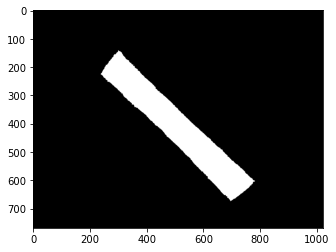

In [34]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv.erode(mask, kernel, iterations=6)
plt.imshow(erosion, cmap='gray')

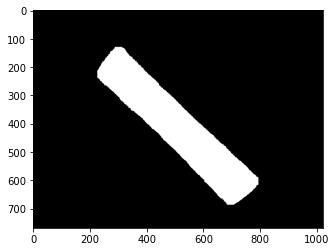

In [35]:
dilation = cv.dilate(erosion, kernel, iterations=6)
plt.imshow(dilation, cmap='gray')
mask = dilation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

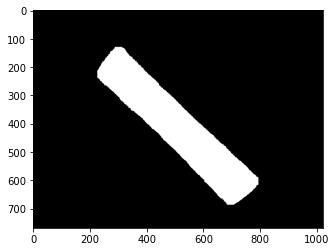

In [36]:
# also: cv2.Canny
contour = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
#black[:, :] = (55, 55, 55)
# не очень понимаю, как это всё работает и почему приходится делать absdiff <- это старое, сейчас всёё понимаю!
contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(mask, cmap='gray')

cv.drawContours(contour, contours, -1, (255, 255, 255), 1)

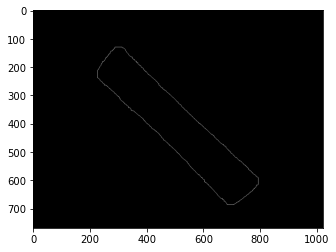

In [37]:
plt.imshow(contour, cmap='gray')

In [38]:
#image[h, w, 3], 1080*1920
h_mass = 0
w_mass = 0
num = 0
for i in range(1, mask.shape[0]):
    for j in range(1, mask.shape[1]):
        if mask[i - 1, j - 1] > 0:
            h_mass += (i - 1)
            w_mass += (j - 1)
            num += 1
h_mass = h_mass / num
w_mass = w_mass / num
print(h_mass, w_mass)
#diff = np.copy(mask)
#contour = cv.absdiff(mask2, mask, diff)
#plt.imshow(contour, cmap='gray')

412.1386273040286 508.5672716608557


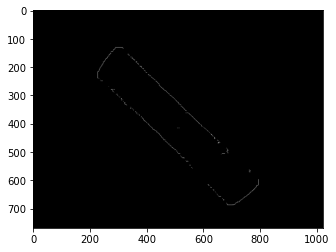

In [39]:
window_size = 23 #better be odd
contour_step = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
for i in range(1, contour.shape[0]):
    for j in range(1, contour.shape[1]):
        if contour[i - 1, j - 1] > 0:
            # приращение
            dw = w_mass - j
            dh = h_mass - i

            # в теории контур может пройти через центр масс => скипаем
            if dw == 0 and dh == 0:
                continue

            # нормируем приращение, чтобы (y + dh, x + dw) было новым следующим пикселем
            max_d = max(abs(dw), abs(dh))
            dw /= max_d
            dh /= max_d

            # k - сколько шагов между (х, y) и центром масс нужно сделать. Да, тут можно просто max_d взять, но раньше
            #   была идея рассматривать всю доступную прямую -- осталось с тех времён, вдруг понадобится.
            # x_bound_1, y_bound_1 - ограничения на k снизу при приращении ширины и высоты, соответственно.
            # x_bound_2, y_bound_2 - ограничения на k сверху.

            if dw == 0:
                x_bound_1 = 0
                x_bound_2 = contour.shape[1]
            else:
                # рассматриваем только отрезок между пикселем и центром масс, не всю прямую
                x_bound_1 = min(0, (w_mass - j) / dw)
                x_bound_2 = max(0, (w_mass - j) / dw)
                # x_bound_1 = min(-j / dw, (contour.shape[1] - 1 - j) / dw)
                # x_bound_2 = max(-j / dw, (contour.shape[1] - 1 - j) / dw)

            if dh == 0:
                y_bound_1 = 0
                y_bound_2 = contour.shape[0]
            else:
                # рассматриваем только отрезок между пикселем и центром масс, не всю прямую
                y_bound_1 = min(0, (h_mass - i) / dh)
                y_bound_2 = max(0, (h_mass - i) / dh)
                #y_bound_1 = min(-i / dh, (contour.shape[0] - 1 - i) / dh)
                #y_bound_2 = max(-i / dh, (contour.shape[0] - 1 - i) / dh)

            min_k = np.int16(np.ceil(max(x_bound_1, y_bound_1))) # min k: x + k * dw >= 0, y + k * dh >= 0
            max_k = np.int16(np.floor(min(x_bound_2, y_bound_2))) # max k: ...

            fm_results = np.zeros(max_k - min_k + 1)
            for k in range(min_k, max_k + 1):
                x = np.int16(np.floor(j + k * dw))
                y = np.int16(np.floor(i + k * dh))

                lower_x = max(0, x - (window_size - 1) // 2)
                upper_x = min(contour.shape[1], x + (window_size - 1) // 2)
                lower_y = max(0, y - (window_size - 1) // 2)
                upper_y = min(contour.shape[0], y + (window_size - 1) // 2)

                # print(lower_x, upper_x, lower_y, upper_y)
                fm_results[k - min_k] = of.LAPM(grayscale_texture[lower_y:upper_y, lower_x:upper_x])

            k_max_focus = np.argmax(fm_results) + min_k
            contour_step[np.uint16(np.floor(i + k_max_focus * dh)), np.uint16(np.floor(j + k_max_focus * dw))] = 255



#print(h_mass / num, w_mass / num)
plt.imshow(contour_step, cmap='gray')

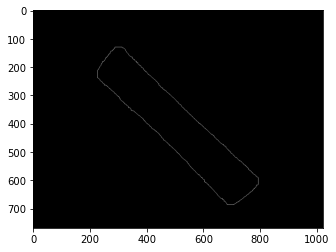

In [40]:
plt.imshow(contour, cmap='gray')
#lines = cv.HoughLines(contour, 1, np.pi / 180, threshold=300)


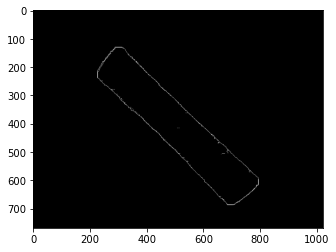

In [44]:
cont = np.add(contour, contour_step)
plt.imshow(np.add(contour, contour_step), cmap='gray')
# black = np.zeros((1080, 1920))
# for rho,theta in lines[:, 0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 2000*(-b))
#     y1 = int(y0 + 2000*(a))
#     x2 = int(x0 - 2000*(-b))
#     y2 = int(y0 - 2000*(a))
#
#     cv.line(black,(x1, y1),(x2,y2),(255,0,0),thickness=2)
#
# # for x1, y1, x2, y2 in lines[:, 0]:
# #     cv.line(black,(x1, y1),(x2,y2),(255,0,0),thickness=2)

In [42]:
#plt.imshow(black, cmap='gray')


In [43]:
# for pixel in black:
#     if pixel > 0:
#         theta_norm = theta + np.pi / 2
#         a = np.cos(theta_norm)
#         b = np.sin(theta_norm)

